In [276]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from sklearn.tree import DecisionTreeClassifier
from pprint import pprint

In [140]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [141]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [ ]:
def cross_validation_split(dataset, folds=3):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [142]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [143]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1): 
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        type_of_feature = FEATURE_TYPES[column_index]
        if type_of_feature == "continuous":
            potential_splits[column_index] = []
            for index in range(len(unique_values)):
                if index != 0:
                    current_value = unique_values[index]
                    previous_value = unique_values[index - 1]
                    potential_split = (current_value + previous_value) / 2

                    potential_splits[column_index].append(potential_split)
                
        else:
            potential_splits[column_index] = unique_values
    
    return potential_splits

In [144]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [145]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [146]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [147]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [148]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [149]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=10):
    
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    else:    
        counter += 1

        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        sub_tree = {question: []}
        
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [150]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")
    
    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [151]:
def calculate_performance(df, tree):

    df["classification"] = df.apply(classify_example, args=(tree,), axis=1)
    df["classification_correct"] = df["classification"] == df["label"]
    tn=0
    tp=0
    fp=0
    fn=0
    for i in range(len(df["label"])):
        if df["label"][i]== 1 and df["classification"][i]==1:
            tp+=1
        elif df["label"][i]== 1 and df["classification"][i]==0:
            fn+=1
        elif df["label"][i]== 0 and df["classification"][i]==1:
            fp+=1
        elif df["label"][i]== 1 and df["classification"][i]==0:
            tn+=1
 
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision= (tp)/(tp+fp)
    recall= (tp)/(tp+fn)
    f1= (2*tp)/((2*tp)+fp+fn)
    return accuracy,precision,recall,f1

In [152]:
df = pd.read_csv("project3_dataset1.csv")

In [153]:
tree = decision_tree_algorithm(df, max_depth=3)
accuracy,precision,recall,f1 = calculate_performance(df, tree)

pprint(tree, width=50)
print("accuracy: ",accuracy)
print("precision: ",precision)
print("recall: ",recall)
print("f1: ",f1)

{'f_23 <= 105.95': [{'f_28 <= 0.13505': [0.0,
                                         {'f_22 <= 27.575': [0.0,
                                                             1.0]}]},
                    {'f_23 <= 117.45': [{'f_25 <= 0.1361': [0.0,
                                                            1.0]},
                                        {'f_28 <= 0.085865': [0.0,
                                                              1.0]}]}]}
accuracy:  0.9154929577464789
precision:  0.9948979591836735
recall:  0.9198113207547169
f1:  0.9558823529411765


In [291]:
df = pd.read_csv("project3_dataset2.csv")

In [292]:
#random.seed(0)
#train_df, test_df = train_test_split(df, 0.2)
tree = decision_tree_algorithm(df, max_depth=5)
accuracy,precision,recall,f1 = calculate_performance(df, tree)

pprint(tree, width=50)
print("accuracy: ",accuracy)
print("precision: ",precision)
print("recall: ",recall)
print("f1: ",f1)

{'f9 <= 31.5': [{'f8 <= 11.105': [{'f7 <= 18.48': [{'f7 <= 18.175': [0,
                                                                     1]},
                                                   0]},
                                  {'f2 <= 0.51': [0,
                                                  {'f7 <= 25.59': [{'f3 <= 4.265000000000001': [0,
                                                                                                1]},
                                                                   {'f9 <= 26.5': [1,
                                                                                   0]}]}]}]},
                {'f9 <= 50.5': [{'f6 <= 68.5': [{'f7 <= 19.83': [1,
                                                                 {'f4 <= 39.495000000000005': [0,
                                                                                               1]}]},
                                                {'f7 <= 23.990000000000002': [0,
                

In [156]:
df = pd.read_csv("project3_dataset4.csv")

In [157]:
#random.seed(0)
#train_df, test_df = train_test_split(df, 0.2)
tree = decision_tree_algorithm(df, max_depth=5)
accuracy,precision,recall,f1 = calculate_performance(df, tree)

pprint(tree, width=50)
print("accuracy: ",accuracy)
print("precision: ",precision)
print("recall: ",recall)
print("f1: ",f1)

{'f_1 = overcast': [1,
                    {'f_3 = normal': [{'f_4 = weak': [1,
                                                      {'f_2 = mild': [1,
                                                                      0]}]},
                                      {'f_1 = sunny': [0,
                                                       {'f_4 = weak': [1,
                                                                       0]}]}]}]}
accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0


In [228]:
def rf_calculate_performance(df, rf):
    tn=0
    tp=0
    fp=0
    fn=0
    for i in df["label"]:
        
        if df["label"][i]== 1 and rf[i]==1:
            tp+=1
        elif df["label"][i]== 1 and rf[i]==0:
            fn+=1
        elif df["label"][i]== 0 and rf[i]==1:
            fp+=1
        elif df["label"][i]== 1 and rf[i]==0:
            tn+=1
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision= (tp)/(tp+fp)
    recall= (tp)/(tp+fn)
    f1= (2*tp)/((2*tp)+fp+fn)
    return accuracy,precision,recall,f1

In [229]:
def rf_algorithm(df, n_trees):
    count_z=0
    count_o=0
    l= df["label"]
    df = df.iloc[:, :-1]
    n_samples = int(len(df))
    n_features = int(len(df.columns))
    df= df.sample(n_features, axis=1)
    results= np.zeros((n_samples,n_trees))
    final= np.zeros((n_samples,1))
    trees=[]
    for i in range(0,n_trees):
        df=df.iloc[np.random.randint(0, len(df), size=n_samples)]
        df["label"]=l
        tree = decision_tree_algorithm(df, max_depth=3)
        results[:,i]= df.apply(classify_example, args=(tree,), axis=1)
    
    for i in range(0,n_samples):
        for j in range(0,n_trees):
            if int(results[i][j])==0:
                count_z+=1
            else:
                count_o+=1
        if count_z>=count_o:
            final[i]= 0
        else:
            final[i]= 1
        count_z=0
        count_o=0
        
    return final

In [230]:
df = pd.read_csv("project3_dataset1.csv")
rf = rf_algorithm(df,3)
accuracy,precision,recall,f1 = rf_calculate_performance(df, rf)
print("accuracy: ",accuracy)
print("precision: ",precision)
print("recall: ",recall)
print("f1: ",f1)

accuracy:  0.37258347978910367
precision:  1.0
recall:  0.37258347978910367
f1:  0.5428937259923176


In [285]:
df = pd.read_csv("project3_dataset1.csv")
train_df, test_df = train_test_split(df, 0.2)

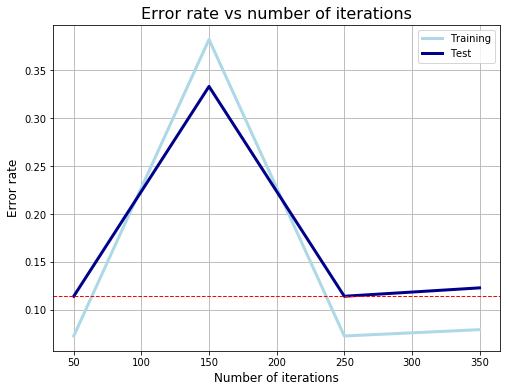

In [290]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))


def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        miss = [int(x) for x in (pred_train_i != Y_train)]
        miss2 = [x if x==1 else -1 for x in miss]
        err_m = np.dot(w,miss) / sum(w)
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

rounds=3
X_train= train_df.iloc[:, :-1]
Y_train= train_df["label"]
X_test= test_df.iloc[:, :-1]
Y_test= test_df["label"]
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)
er_train, er_test = [er_tree[0]], [er_tree[1]]
for i in range(rounds):    
        er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
        er_train.append(er_i[0])
        er_test.append(er_i[1])
plot_error_rate(er_train, er_test)